Ignoring empty camera frame.


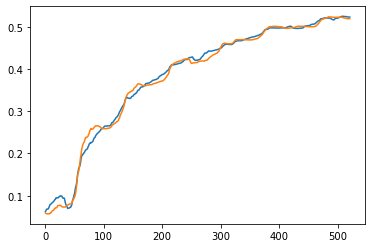

In [1]:
import cv2
import mediapipe as mp
import matplotlib.pyplot as plt
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_pose = mp.solutions.pose

# For webcam input:
#cap = cv2.VideoCapture(0)
cap = cv2.VideoCapture(r"C:\Users\Hp\Documents\Lausanne\EPFL\Courses\MA3\sensi\Project\Data\videos\video_camil_cut.mp4")
ys_l_shoulder = []
ys_r_shoulder = []
with mp_pose.Pose(
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5) as pose:
  while cap.isOpened():
    success, image = cap.read()
    if not success:
      print("Ignoring empty camera frame.")
      # If loading a video, use 'break' instead of 'continue'.
      break

    # To improve performance, optionally mark the image as not writeable to
    # pass by reference.
    image.flags.writeable = False
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = pose.process(image)

    # Draw the pose annotation on the image.
    image.flags.writeable = True
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    if results.pose_landmarks!=None :
        #print(results.pose_landmarkss)
        landmarks = [(data_point.x, data_point.y, data_point.z) for data_point in results.pose_landmarks.landmark]
        # y is important for distance
        ys_l_shoulder.append(landmarks[12][1])
        ys_r_shoulder.append(landmarks[11][1])

#mp_drawing.draw_landmarks(
#        image,
#        results.pose_landmarks,
#        mp_pose.POSE_CONNECTIONS,
#        landmark_drawing_spec=mp_drawing_styles.get_default_pose_landmarks_style())
    # Flip the image horizontally for a selfie-view display.
    cv2.imshow('MediaPipe Pose', cv2.flip(image, 1))
    if cv2.waitKey(5) & 0xFF == 27:
      break


plt.plot(ys_l_shoulder)
plt.plot(ys_r_shoulder)
plt.show()
cap.release()

In [3]:
import numpy as np
import scipy.optimize

def func(x,y):
    h_sh = 1.5 # tbd
    fov = 77/180 * np.pi
    alpha = 45/180*np.pi-fov/2 # tbd
    gamma = np.arctan(x/h_sh)
    delta = np.pi/2 - fov/2 - alpha - gamma
    ai = h_sh + x*np.tan(np.pi/2-fov/2-alpha)
    ah = ai * np.sin(fov/2+alpha)
    lh = ah * np.tan(fov/2)
    lm = 2*lh
    ap = h_sh/np.cos(gamma)
    ph = ap*np.sin(delta)
    funz = 1/2-ph/lm-y
    
    return funz

inc = scipy.optimize.fsolve(func, 0, args=(2))

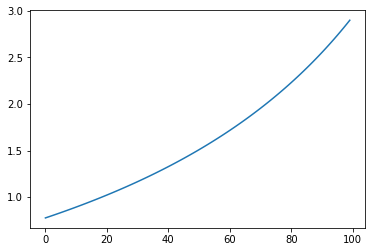

In [31]:
y = np.linspace(0.3,0.7,100)
z = []
for i in y:
    
    z.append(scipy.optimize.fsolve(func,0,args=(i)))
    
    
plt.plot(z)

In [ ]:
# For static images:
IMAGE_FILES = []
BG_COLOR = (192, 192, 192) # gray
with mp_pose.Pose(
    static_image_mode=True,
    model_complexity=2,
    enable_segmentation=True,
    min_detection_confidence=0.5) as pose:
  for idx, file in enumerate(IMAGE_FILES):
    image = cv2.imread(file)
    image_height, image_width, _ = image.shape
    # Convert the BGR image to RGB before processing.
    results = pose.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

    if not results.pose_landmarks:
      continue
    print(
        f'Nose coordinates: ('
        f'{results.pose_landmarks.landmark[mp_pose.PoseLandmark.NOSE].x * image_width}, '
        f'{results.pose_landmarks.landmark[mp_pose.PoseLandmark.NOSE].y * image_height})'
    )

    annotated_image = image.copy()
    # Draw segmentation on the image.
    # To improve segmentation around boundaries, consider applying a joint
    # bilateral filter to "results.segmentation_mask" with "image".
    condition = np.stack((results.segmentation_mask,) * 3, axis=-1) > 0.1
    bg_image = np.zeros(image.shape, dtype=np.uint8)
    bg_image[:] = BG_COLOR
    annotated_image = np.where(condition, annotated_image, bg_image)
    # Draw pose landmarks on the image.
    mp_drawing.draw_landmarks(
        annotated_image,
        results.pose_landmarks,
        mp_pose.POSE_CONNECTIONS,
        landmark_drawing_spec=mp_drawing_styles.get_default_pose_landmarks_style())
    cv2.imwrite('/tmp/annotated_image' + str(idx) + '.png', annotated_image)
    # Plot pose world landmarks.
    mp_drawing.plot_landmarks(
        results.pose_world_landmarks, mp_pose.POSE_CONNECTIONS)